In [134]:
import os
from collections import defaultdict #dict subclass that calls a factory function to supply missing values
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Table of contents
- 0: Goal Definition
- 1: Data Acquisition
- 2: Data Exploration
- 3: Preprocessing
- 4: Processing
- 5: Validation

## 0: Goal definition

The goal of this project is to classify Microsoft Portable Executable files as malware or non-malware using only the informations available in their headers.

## 1: Data Acquisition

The dataset was taken from a kaggle repository

## 2: Data Exploration

In [135]:
file = open('dataset/ClaMP_Integrated-5184.csv')
df = pd.read_csv(file, skip_blank_lines=True, na_filter=False, encoding='utf-8')

In [136]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5210 entries, 0 to 5209
Data columns (total 70 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   e_cblp                       5210 non-null   int64  
 1   e_cp                         5210 non-null   int64  
 2   e_cparhdr                    5210 non-null   int64  
 3   e_maxalloc                   5210 non-null   int64  
 4   e_sp                         5210 non-null   int64  
 5   e_lfanew                     5210 non-null   int64  
 6   NumberOfSections             5210 non-null   int64  
 7   CreationYear                 5210 non-null   int64  
 8   FH_char0                     5210 non-null   int64  
 9   FH_char1                     5210 non-null   int64  
 10  FH_char2                     5210 non-null   int64  
 11  FH_char3                     5210 non-null   int64  
 12  FH_char4                     5210 non-null   int64  
 13  FH_char5          

In [137]:
df.describe()

,e_cblp,e_cp,e_cparhdr,e_maxalloc,e_sp,e_lfanew,NumberOfSections,CreationYear,FH_char0,FH_char1,...,LoaderFlags,sus_sections,non_sus_sections,packer,E_text,E_data,filesize,E_file,fileinfo,class
count,5210.000000,5210.000000,5210.000000,5210.000000,5210.000000,5210.000000,5210.000000,5210.000000,5210.000000,5210.0,...,5210.000000,5210.000000,5210.000000,5210.000000,5210.000000,5210.000000,5.210000e+03,5210.000000,5210.000000,5210.000000
mean,152.658733,10.633589,8.903263,65137.618234,202.530902,222.833013,4.662956,0.990403,0.362764,1.0,...,0.999040,1.360845,3.302111,0.156430,4.939586,2.523549,7.875718e+05,6.364756,0.544146,0.522457
std,616.499070,392.745064,251.685103,5005.606042,968.625098,48.591497,1.922882,0.097502,0.480844,0.0,...,0.030967,1.623972,1.146956,0.363297,2.521787,2.685909,5.293440e+06,1.119881,0.498095,0.499543
min,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,1.000000,0.000000,0.000000,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.536000e+03,0.939626,0.000000,0.000000
25%,144.000000,3.000000,4.000000,65535.000000,184.000000,208.000000,4.000000,1.000000,0.000000,1.0,...,1.000000,1.000000,3.000000,0.000000,3.886006,0.000000,6.144000e+04,5.695785,0.000000,0.000000
50%,144.000000,3.000000,4.000000,65535.000000,184.000000,232.000000,5.000000,1.000000,0.000000,1.0,...,1.000000,1.000000,4.000000,0.000000,6.148211,1.555973,1.218560e+05,6.390618,1.000000,1.000000
75%,144.000000,3.000000,4.000000,65535.000000,184.000000,248.000000,5.000000,1.000000,1.000000,1.0,...,1.000000,2.000000,4.000000,0.000000,6.507072,4.685836,3.055480e+05,7.314531,1.000000,1.000000
max,37008.000000,20050.000000,12851.000000,65535.000000,65534.000000,648.000000,34.000000,1.000000,1.000000,1.0,...,1.000000,31.000000,8.000000,1.000000,7.999859,7.999620,1.657081e+08,7.999997,1.000000,1.000000


In [138]:
df.isnull().sum()

e_cblp        0
e_cp          0
e_cparhdr     0
e_maxalloc    0
e_sp          0
             ..
E_data        0
filesize      0
E_file        0
fileinfo      0
class         0
Length: 70, dtype: int64

In [139]:
df.describe()

,e_cblp,e_cp,e_cparhdr,e_maxalloc,e_sp,e_lfanew,NumberOfSections,CreationYear,FH_char0,FH_char1,...,LoaderFlags,sus_sections,non_sus_sections,packer,E_text,E_data,filesize,E_file,fileinfo,class
count,5210.000000,5210.000000,5210.000000,5210.000000,5210.000000,5210.000000,5210.000000,5210.000000,5210.000000,5210.0,...,5210.000000,5210.000000,5210.000000,5210.000000,5210.000000,5210.000000,5.210000e+03,5210.000000,5210.000000,5210.000000
mean,152.658733,10.633589,8.903263,65137.618234,202.530902,222.833013,4.662956,0.990403,0.362764,1.0,...,0.999040,1.360845,3.302111,0.156430,4.939586,2.523549,7.875718e+05,6.364756,0.544146,0.522457
std,616.499070,392.745064,251.685103,5005.606042,968.625098,48.591497,1.922882,0.097502,0.480844,0.0,...,0.030967,1.623972,1.146956,0.363297,2.521787,2.685909,5.293440e+06,1.119881,0.498095,0.499543
min,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,1.000000,0.000000,0.000000,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.536000e+03,0.939626,0.000000,0.000000
25%,144.000000,3.000000,4.000000,65535.000000,184.000000,208.000000,4.000000,1.000000,0.000000,1.0,...,1.000000,1.000000,3.000000,0.000000,3.886006,0.000000,6.144000e+04,5.695785,0.000000,0.000000
50%,144.000000,3.000000,4.000000,65535.000000,184.000000,232.000000,5.000000,1.000000,0.000000,1.0,...,1.000000,1.000000,4.000000,0.000000,6.148211,1.555973,1.218560e+05,6.390618,1.000000,1.000000
75%,144.000000,3.000000,4.000000,65535.000000,184.000000,248.000000,5.000000,1.000000,1.000000,1.0,...,1.000000,2.000000,4.000000,0.000000,6.507072,4.685836,3.055480e+05,7.314531,1.000000,1.000000
max,37008.000000,20050.000000,12851.000000,65535.000000,65534.000000,648.000000,34.000000,1.000000,1.000000,1.0,...,1.000000,31.000000,8.000000,1.000000,7.999859,7.999620,1.657081e+08,7.999997,1.000000,1.000000


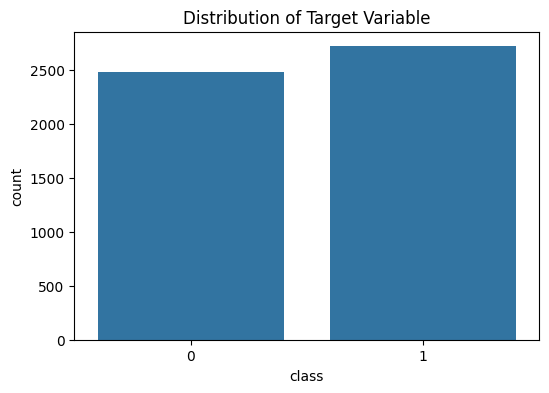

In [140]:
plt.figure(figsize=(6, 4))
sns.countplot(x='class', data=df)
plt.title('Distribution of Target Variable')
plt.show()


In [141]:
df['e_cblp'].nunique()

10

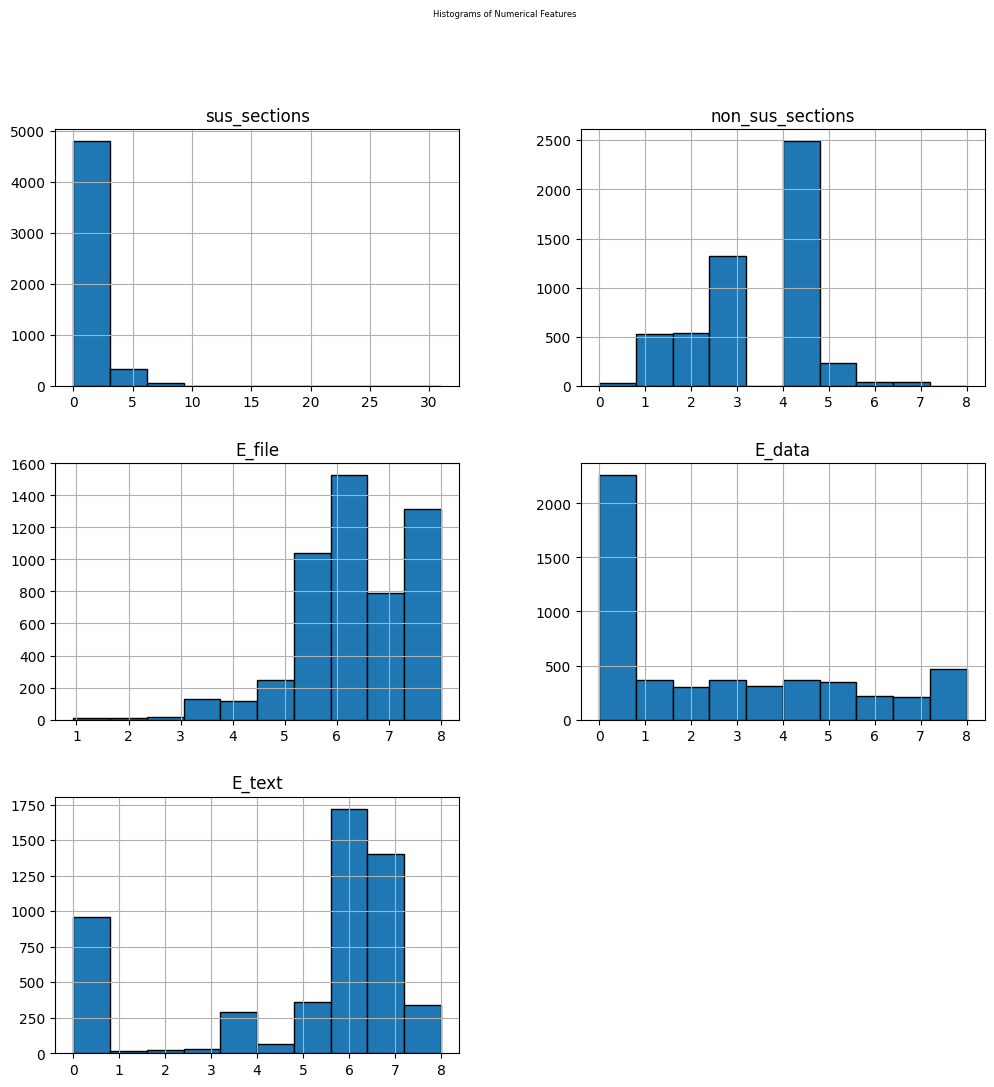

In [142]:
# df.select_dtypes(include=[np.number]).loc[:, df.nunique() >= 3].hist(figsize=(25, 25), bins=10, edgecolor='black')
df[['sus_sections','non_sus_sections','E_file','E_data','E_text']].hist(figsize=(12, 12), bins=10, edgecolor='black')
plt.suptitle('Histograms of Numerical Features', size=6)
plt.show()


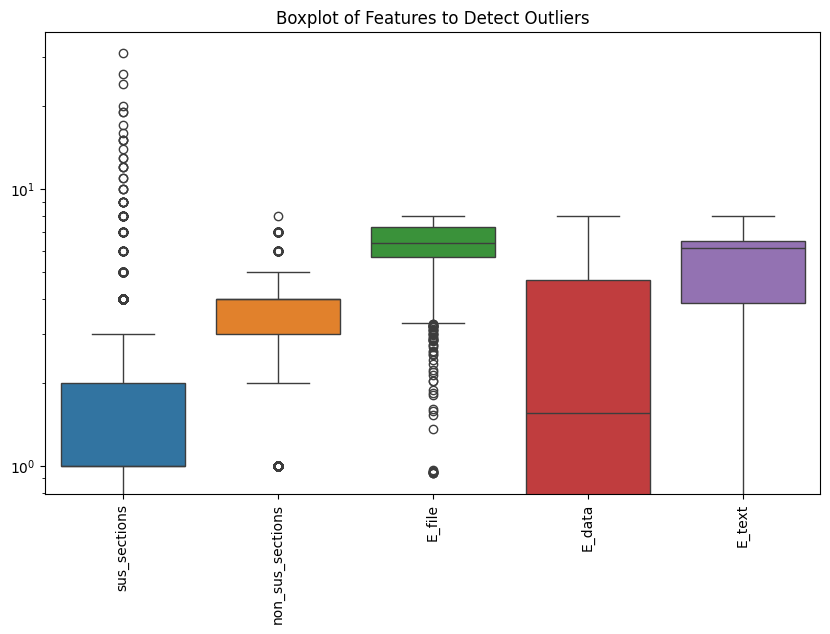

In [143]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['sus_sections','non_sus_sections','E_file','E_data','E_text']])
plt.title('Boxplot of Features to Detect Outliers')
plt.xticks(rotation=90)
plt.yscale('log')
plt.show()


In [144]:
from scipy.stats import zscore
numeric_df = df[['sus_sections','non_sus_sections','E_file','E_data','E_text']]
# Calculate Z-scores for each data point
z_scores = zscore(numeric_df.values)
# Define a threshold for identifying outliers
threshold = 3
# Identify outliers
outliers = (z_scores > threshold) | (z_scores < -threshold)

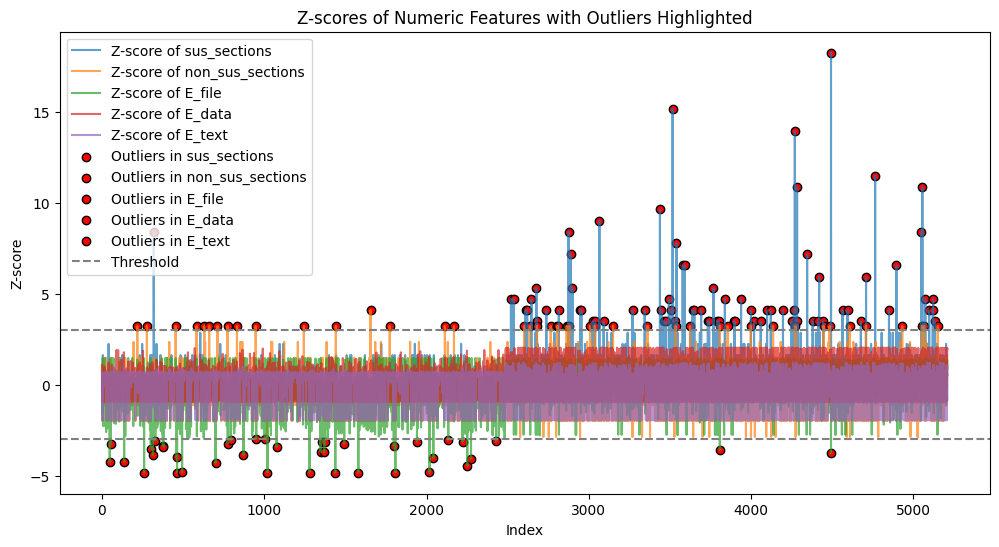

In [145]:
fig, ax = plt.subplots(figsize=(12, 6))

# Plot Z-scores for each feature
for i, col in enumerate(numeric_df.columns):
    ax.plot(z_scores[:, i], label=f'Z-score of {col}', alpha=0.7)

# Highlight outliers
for i, col in enumerate(numeric_df.columns):
    outlier_indices = np.where(outliers[:, i])[0]  # Indices where outliers occur
    ax.scatter(outlier_indices, z_scores[outliers[:, i], i], color='red', label=f'Outliers in {col}', edgecolor='black')

# Add horizontal lines for threshold
ax.axhline(threshold, color='grey', linestyle='--', label='Threshold')
ax.axhline(-threshold, color='grey', linestyle='--')

# Add labels and legend
ax.set_xlabel('Index')
ax.set_ylabel('Z-score')
ax.set_title('Z-scores of Numeric Features with Outliers Highlighted')
ax.legend(loc='best')

plt.show()

In [146]:
# Count the number of outliers in each row
outliers_count = np.sum(outliers, axis=1)

# Count the total number of rows that have at least one outlier
total_outliers = np.sum(outliers_count > 0)

print(f"Total number of rows with outliers: {total_outliers}")

Total number of rows with outliers: 156


# TODO OUTLIER DETECTION

The dataset is well balanced, as observable by the mean value of the class entry.

From the the dataframe info the presence of a nominal data type can also be observed.

TODO: Description of packer_type field, use of a packer

There are a total of 40 nominal values for this entry

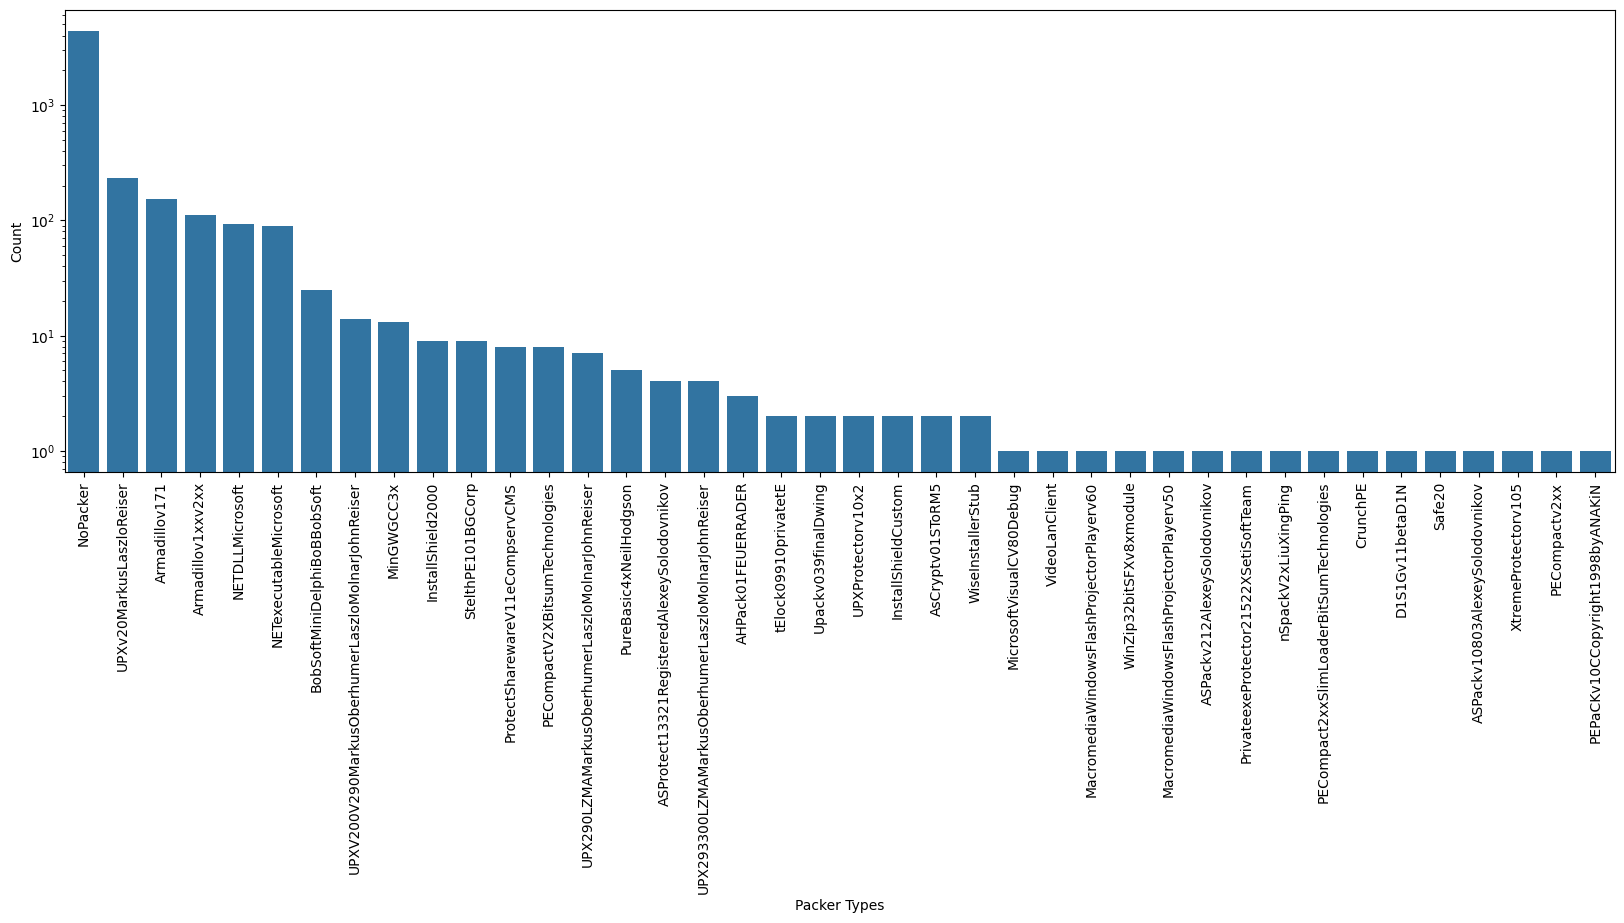

In [147]:
plt.figure(figsize=(20, 6))
axes = sns.countplot(df, x='packer_type', order=df['packer_type'].value_counts().index)
axes.set_yscale('log')
axes.set_xlabel('Packer Types')
axes.set_ylabel('Count')
plt.xticks(rotation='vertical')
plt.show()

The packer_type feature has a relatively high cardinality and has mostly an empty value of "NoPacker", to convert it to an usable value one-hot encoding is used, keeping in mind however that there must be a feature reduction step to prune the useless features generated by this step.

In [148]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
raw_new_data = ohe.fit_transform(df[['packer_type']]).astype(int).toarray()
new_feature_names = ohe.get_feature_names_out(['packer_type'])

encoded_data = pd.DataFrame(raw_new_data, columns=new_feature_names)

encoded_data.reset_index(drop=True, inplace=True)
df.reset_index(drop=True, inplace=True)

df = pd.concat([df.drop(columns=['packer_type']), encoded_data], axis=1)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5210 entries, 0 to 5209
Columns: 109 entries, e_cblp to packer_type_tElock09910privatetE
dtypes: float64(3), int64(106)
memory usage: 4.3 MB


## 3: Data Preprocessing

In [149]:
from sklearn.model_selection import train_test_split

X = df.drop(['class'], axis=1)
Y = df['class']

train_x, test_x, train_y, test_y = train_test_split(
    X,Y,
    test_size=0.20,  
    random_state=666)

print(train_x.shape)
print(test_x.shape)


(4168, 108)
(1042, 108)


#### Feature Selection
Drop constant features

In [150]:

constant_columns = [col for col in train_x.columns if train_x[col].nunique() == 1]

# Drop those constant columns from the DataFrame
train_x_proc = train_x.drop(columns=constant_columns)

train_y_proc = train_y

train_x_proc.shape

(4168, 88)

In [151]:
""" columns_to_check = train_x_proc.select_dtypes(include=[np.number]).loc[:, train_x_proc.nunique() >= 3].columns

# Step 2: Calculate IQR and filter out outliers
for col in columns_to_check:
    Q1 = train_x_proc[col].quantile(0.25)
    Q3 = train_x_proc[col].quantile(0.75)
    IQR = Q3 - Q1

    # Define bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter out outliers in the current column
    train_x_proc = train_x_proc[(train_x_proc[col] >= lower_bound) & (train_x_proc[col] <= upper_bound)] """

' columns_to_check = train_x_proc.select_dtypes(include=[np.number]).loc[:, train_x_proc.nunique() >= 3].columns\n\n# Step 2: Calculate IQR and filter out outliers\nfor col in columns_to_check:\n    Q1 = train_x_proc[col].quantile(0.25)\n    Q3 = train_x_proc[col].quantile(0.75)\n    IQR = Q3 - Q1\n\n    # Define bounds for outliers\n    lower_bound = Q1 - 1.5 * IQR\n    upper_bound = Q3 + 1.5 * IQR\n\n    # Filter out outliers in the current column\n    train_x_proc = train_x_proc[(train_x_proc[col] >= lower_bound) & (train_x_proc[col] <= upper_bound)] '

In [152]:
""" plt.figure(figsize=(10, 6))
sns.boxplot(data=train_x_proc.select_dtypes(include=[np.number]).loc[:, df.nunique() >= 3])
plt.title('Boxplot of Features to Detect Outliers')
plt.xticks(rotation=90)
plt.yscale('log')
plt.show() """

" plt.figure(figsize=(10, 6))\nsns.boxplot(data=train_x_proc.select_dtypes(include=[np.number]).loc[:, df.nunique() >= 3])\nplt.title('Boxplot of Features to Detect Outliers')\nplt.xticks(rotation=90)\nplt.yscale('log')\nplt.show() "

In [153]:
train_x_proc.shape

(4168, 88)

In [154]:
from scipy.stats import zscore
train_x_proc_o = train_x_proc[['sus_sections','non_sus_sections','E_file','E_data','E_text']]
# Calculate Z-scores for each data point
z_scores = zscore(train_x_proc_o.values)
# Define a threshold for identifying outliers
threshold = 3
# Identify outliers
outliers = (z_scores > threshold) | (z_scores < -threshold)

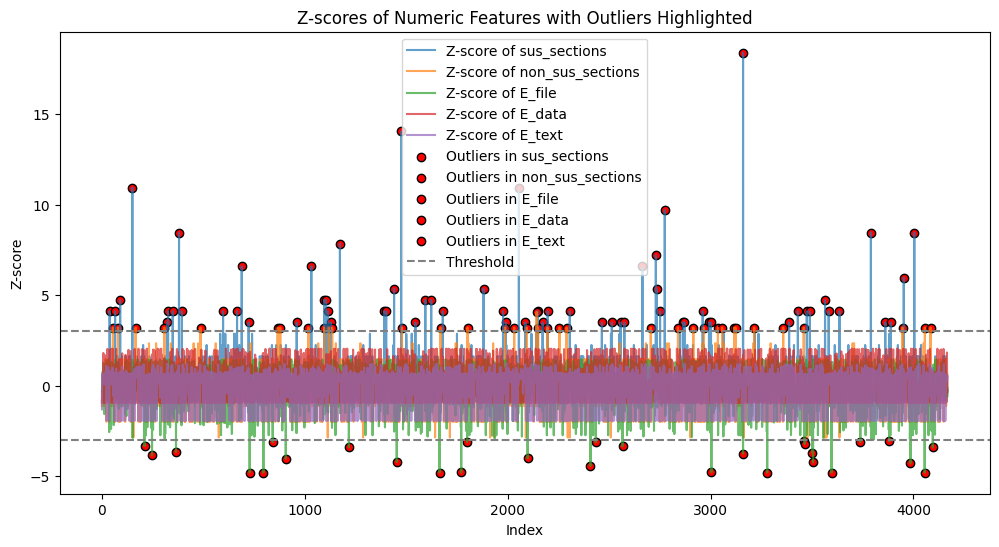

In [155]:
fig, ax = plt.subplots(figsize=(12, 6))

# Plot Z-scores for each feature
for i, col in enumerate(numeric_df.columns):
    ax.plot(z_scores[:, i], label=f'Z-score of {col}', alpha=0.7)

# Highlight outliers
for i, col in enumerate(numeric_df.columns):
    outlier_indices = np.where(outliers[:, i])[0]  # Indices where outliers occur
    ax.scatter(outlier_indices, z_scores[outliers[:, i], i], color='red', label=f'Outliers in {col}', edgecolor='black')

# Add horizontal lines for threshold
ax.axhline(threshold, color='grey', linestyle='--', label='Threshold')
ax.axhline(-threshold, color='grey', linestyle='--')

# Add labels and legend
ax.set_xlabel('Index')
ax.set_ylabel('Z-score')
ax.set_title('Z-scores of Numeric Features with Outliers Highlighted')
ax.legend(loc='best')

plt.show()

In [156]:

# Create a boolean mask where False indicates the presence of an outlier
outliers_mask = np.any(outliers, axis=1)

train_x_proc = train_x_proc[~outliers_mask]

train_y_proc = train_y[~outliers_mask]


print(train_x_proc.shape)
train_y_proc.shape

(4040, 88)


(4040,)

In [157]:
constant_columns = [col for col in train_x_proc.columns if train_x_proc[col].nunique() == 1]

# Drop those constant columns from the DataFrame
train_x_proc = train_x_proc.drop(columns=constant_columns)

train_x_proc.shape

(4040, 86)

In [158]:
train_full = pd.concat([train_x_proc, train_y_proc], axis=1)

train_full.shape

(4040, 87)

In [159]:
corr_matrix = train_full.corr(method='pearson').round(2)

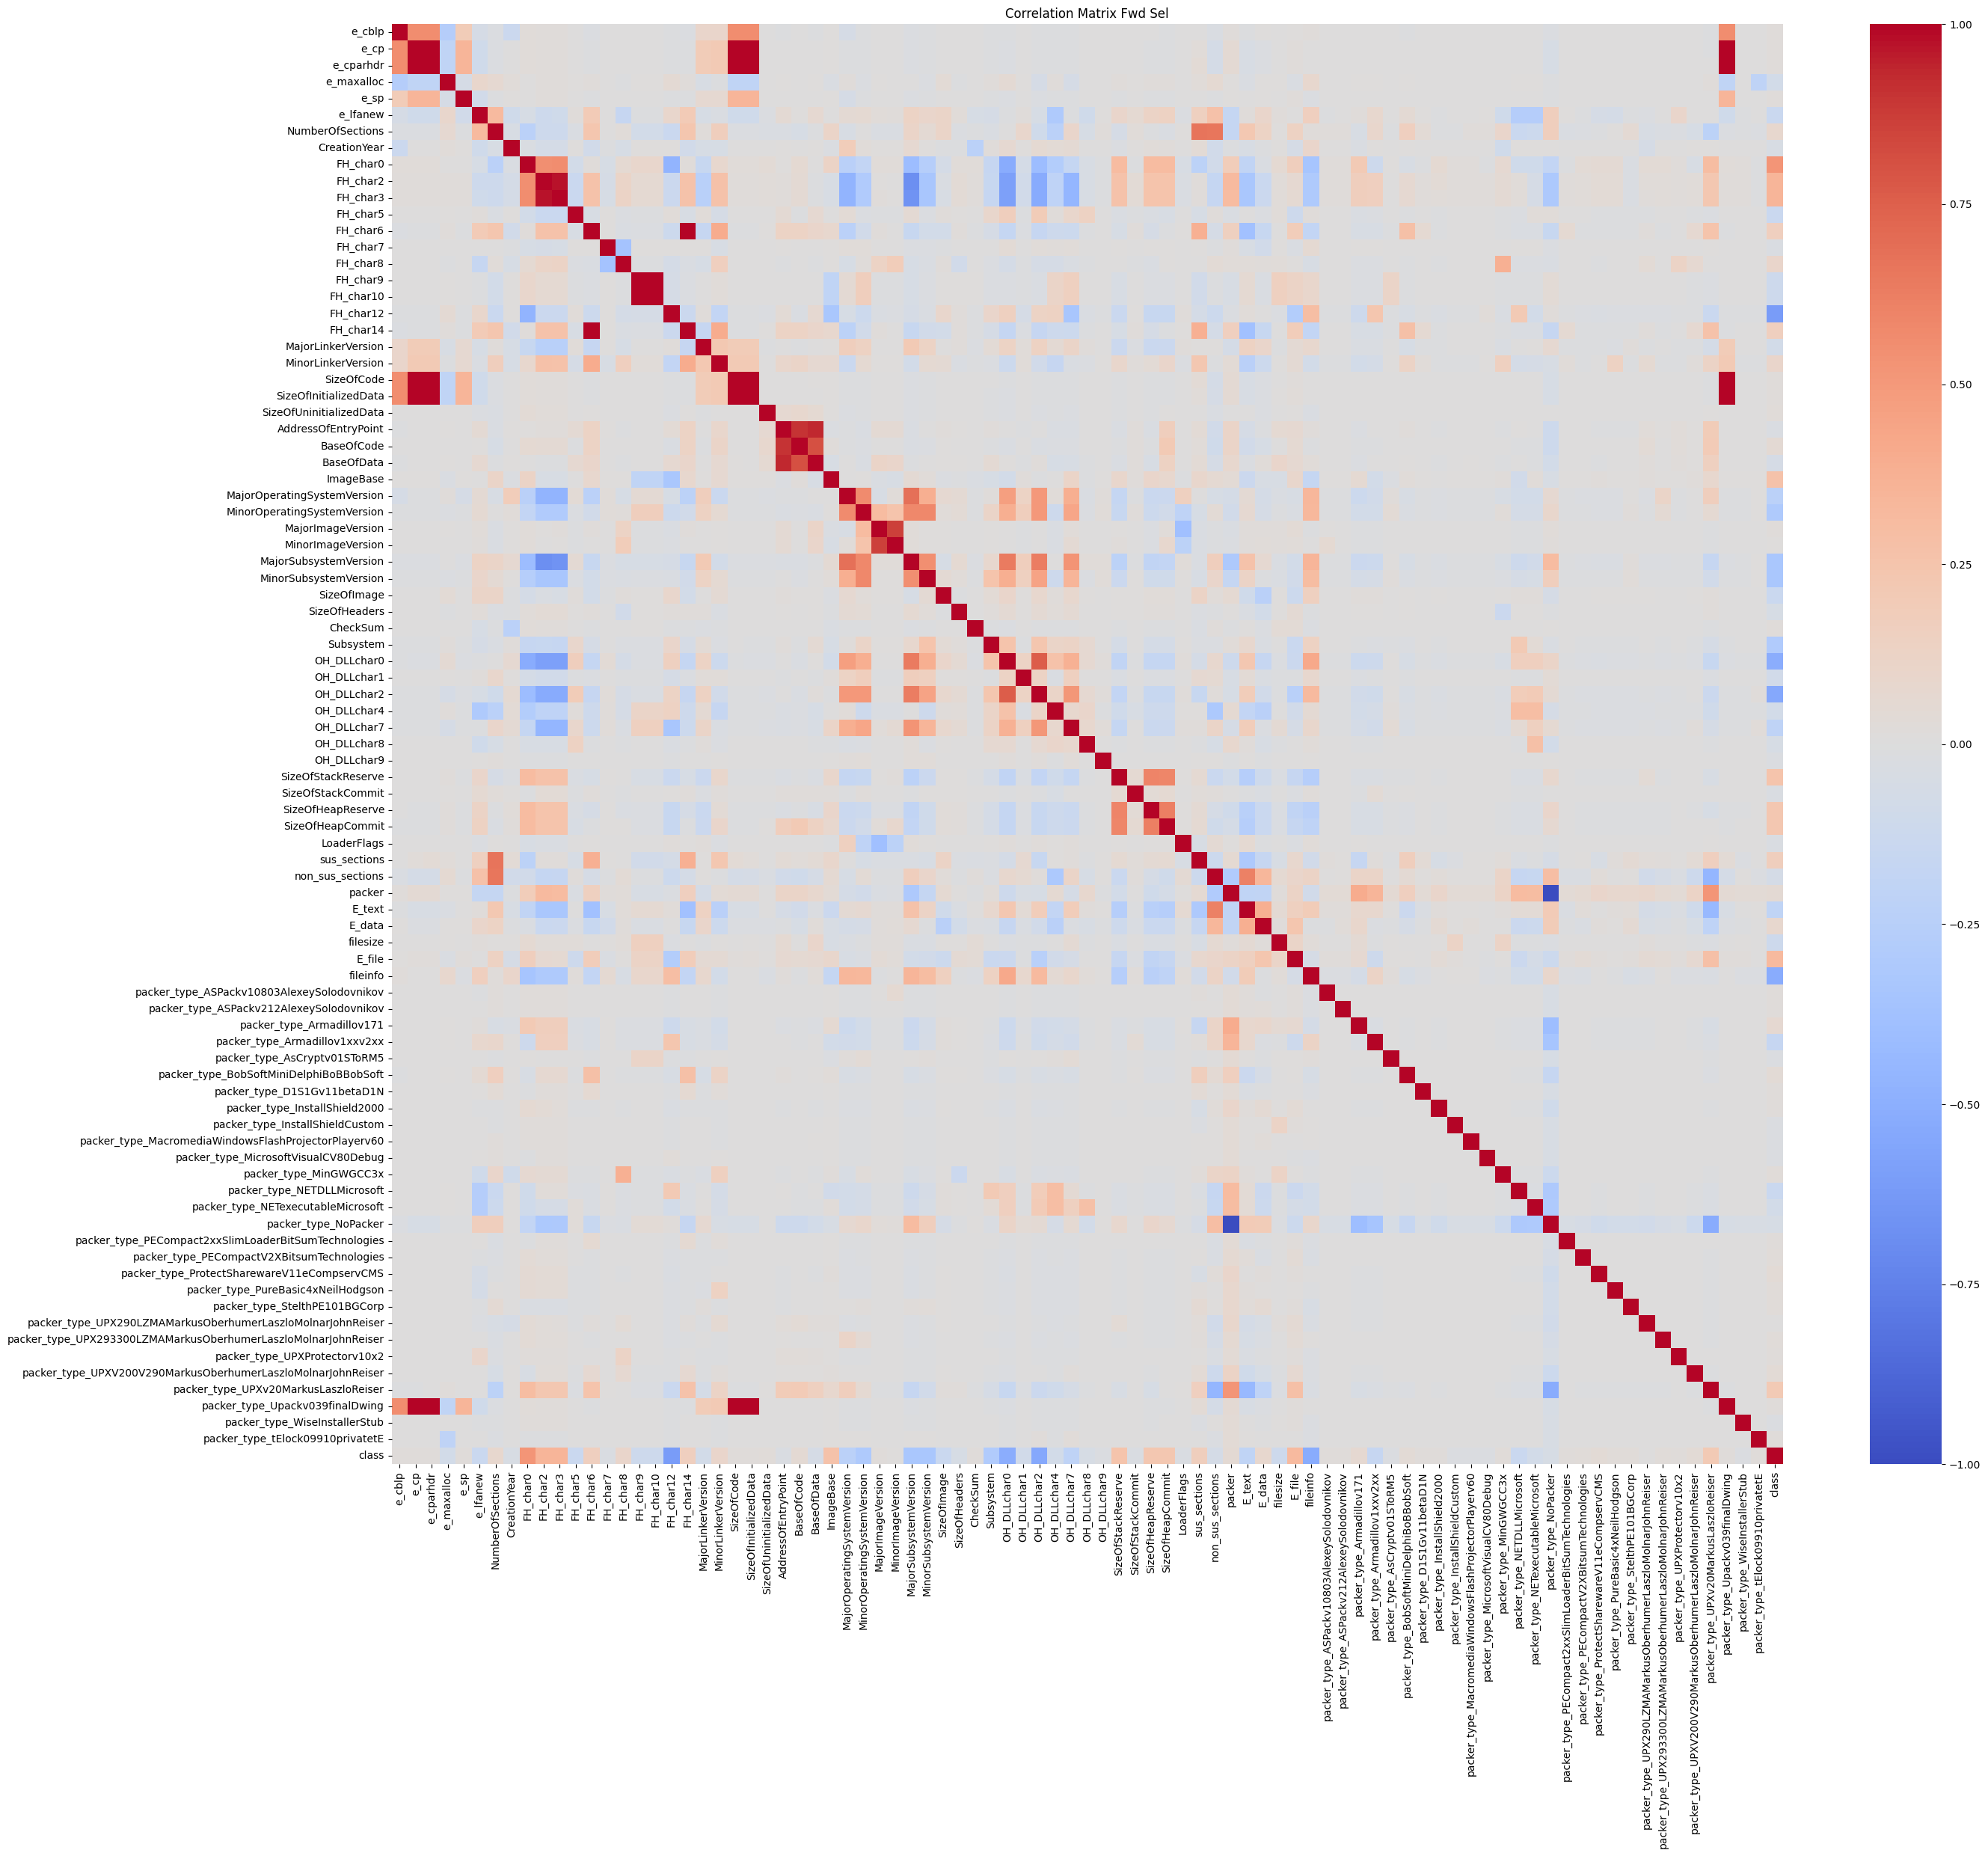

In [160]:
plt.figure(figsize=(30, 25))
sns.heatmap(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Fwd Sel')
plt.show()

In [161]:
correlation_with_class = corr_matrix['class'].abs()
selected_features = correlation_with_class[correlation_with_class >= 0.1].index

# Step 3: Update the dataset by retaining only the selected features
train_full_filtered = train_full[selected_features]

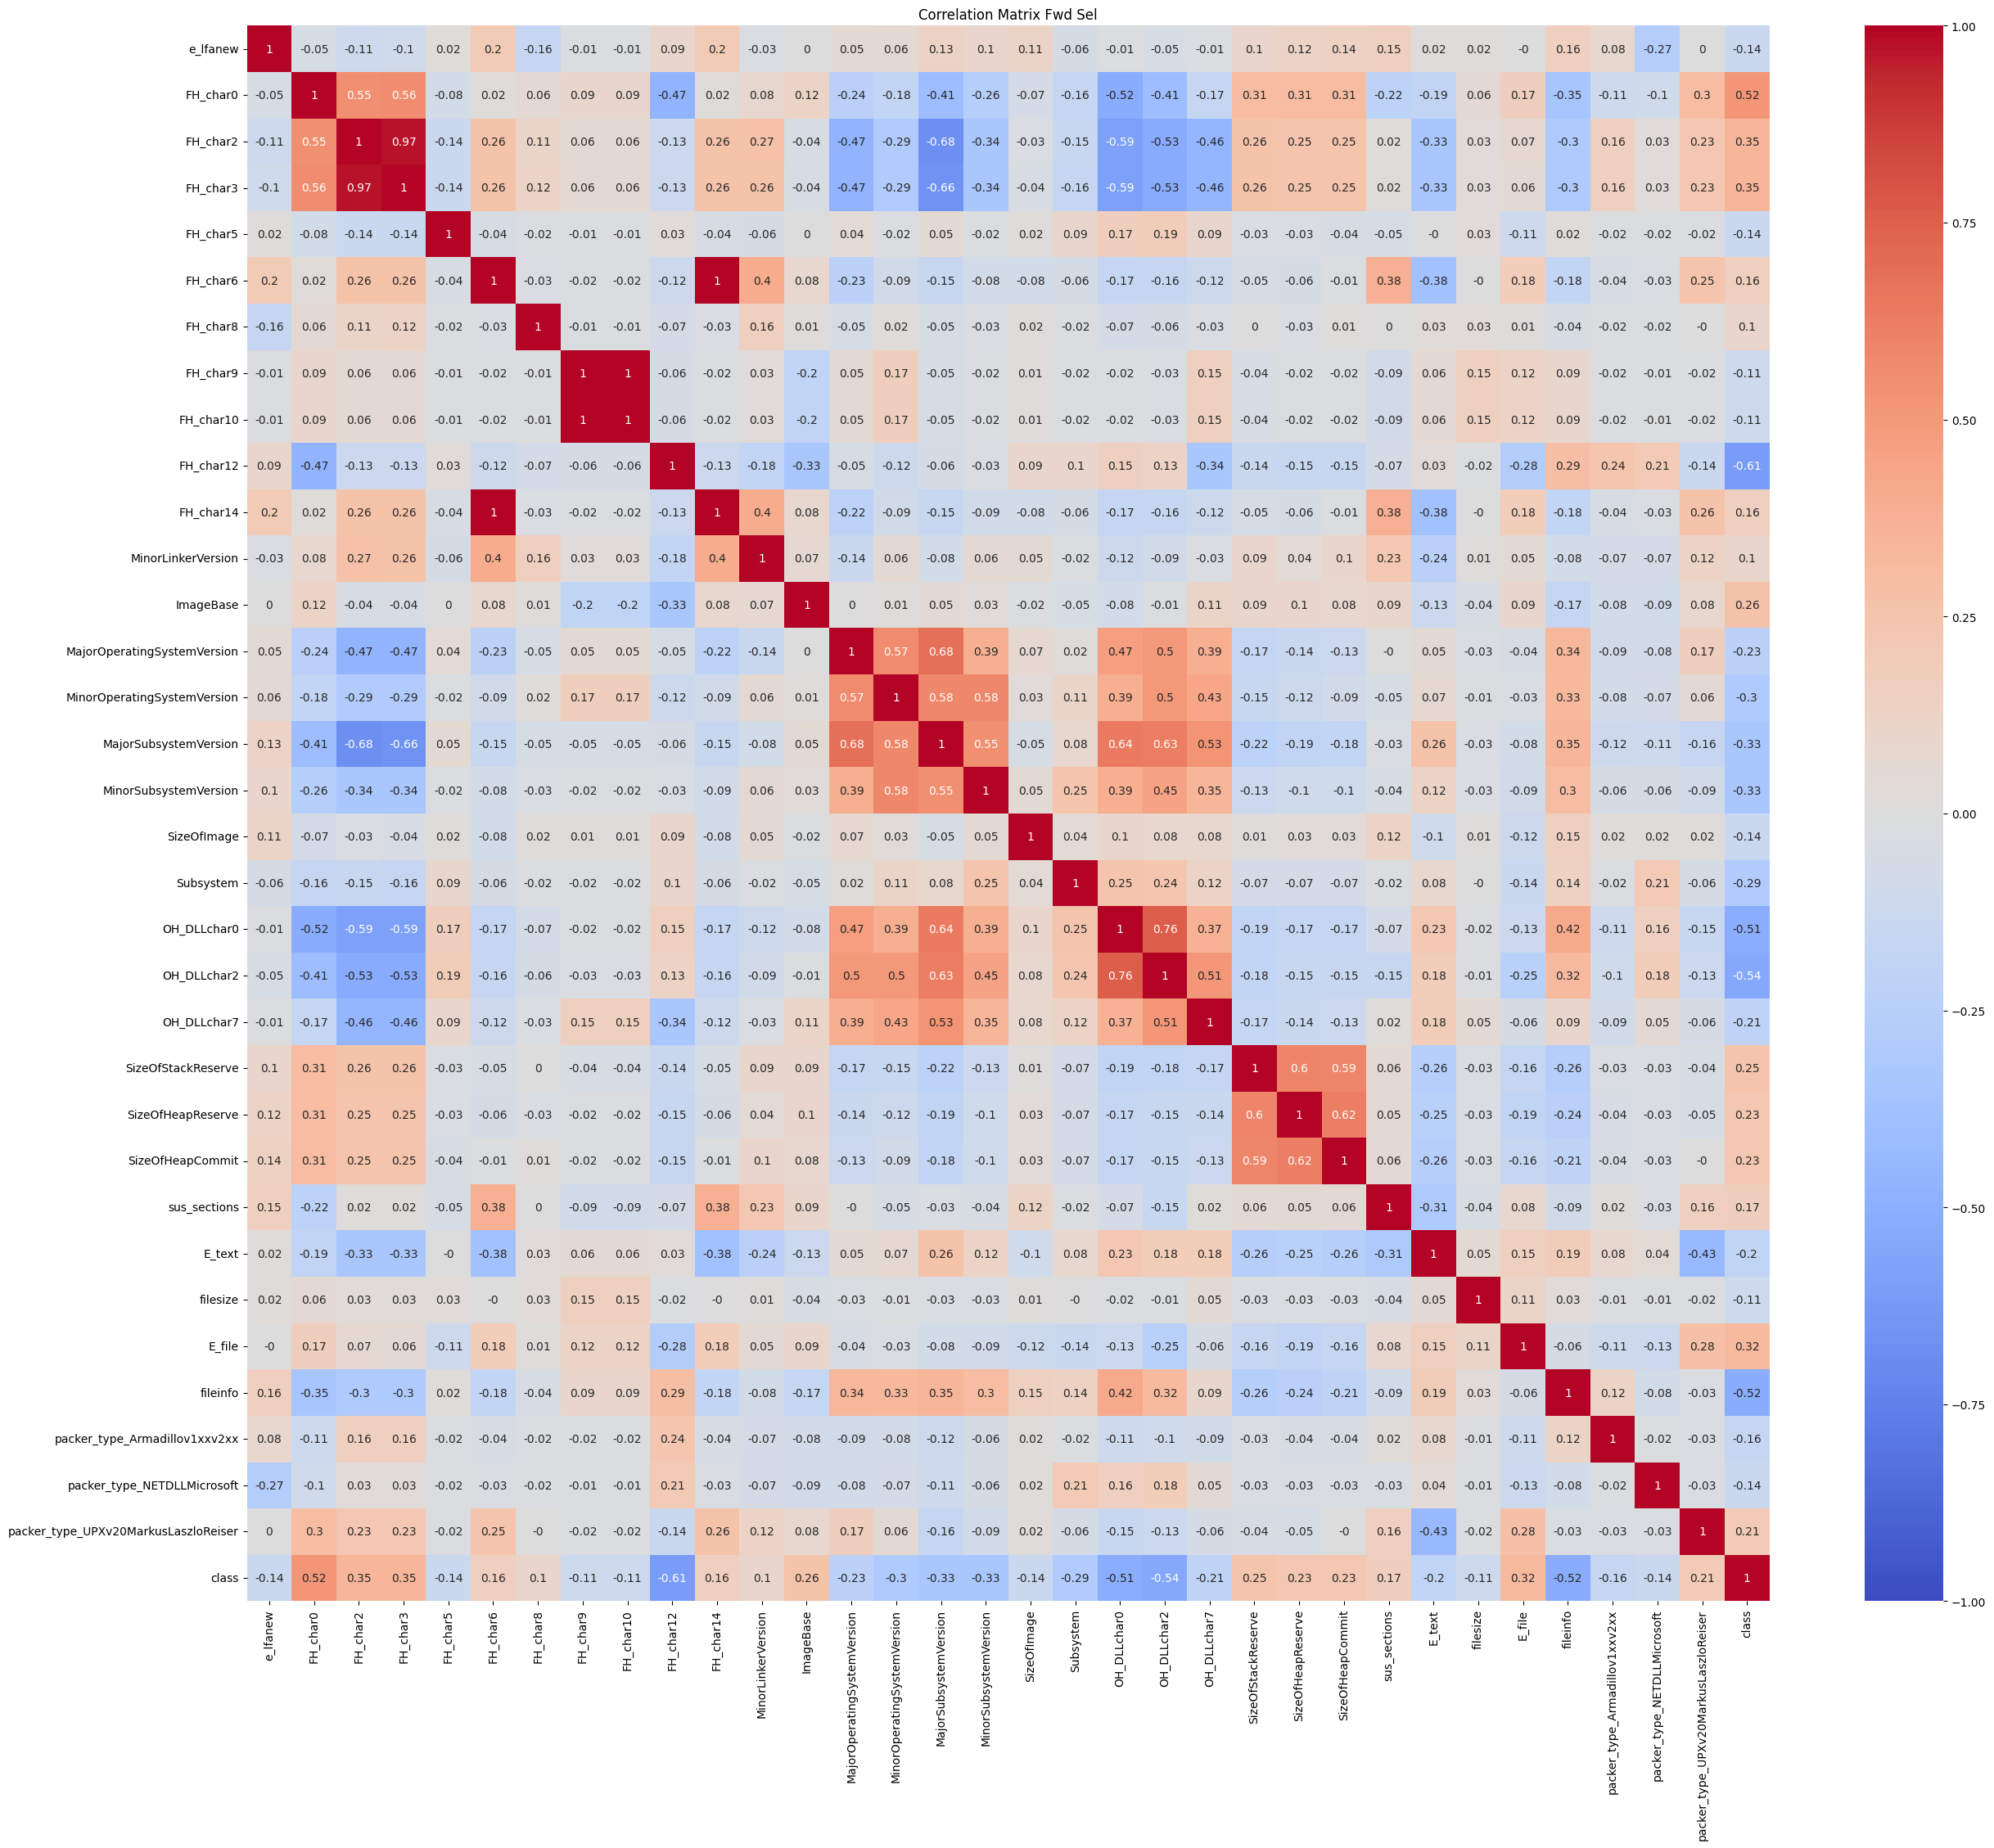

In [162]:
corr_matrix = train_full_filtered.corr(method='pearson').round(2)

plt.figure(figsize=(30,25))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Fwd Sel')
plt.show()

In [163]:
train_x_filtered = train_full_filtered.drop(columns=['class'])

In [164]:
from scipy.stats import chi2_contingency

def compute_chi2(candidates):
    records = {}
    for c in candidates:
        contingency_table = pd.crosstab(train_full_filtered[c], train_full_filtered['class'])
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        records[c] = (chi2, p, dof, expected)
        print(f"Feature {c}: Chi-Square={chi2}, P-Value={p}, Degrees-Of-Freedom={dof}")

to_remove = []

#### **Correlated features: SizeOfCode, SizeOfInitializedData**


In [165]:

candidates = ['FH_char0', 'FH_char2', 'FH_char3']
compute_chi2(candidates)


Feature FH_char0: Chi-Square=1104.6886062395624, P-Value=3.161148636830068e-242, Degrees-Of-Freedom=1
Feature FH_char2: Chi-Square=493.1401834393907, P-Value=2.9549380351141553e-109, Degrees-Of-Freedom=1
Feature FH_char3: Chi-Square=503.09496490829997, P-Value=2.016380608775367e-111, Degrees-Of-Freedom=1


Given the low chi squared values of e_cparhdr, e_cp, packer_type_Upackv039finalDwing and e_cblp they will be discarded

In [166]:
#train_x_filtered = train_x_filtered.drop(columns=['FH_char2'])
to_remove += ['FH_char2','FH_char3']

to_remove

['FH_char2', 'FH_char3']

In [167]:
""" candidates = ['e_cblp', 'e_cp']
compute_chi2(candidates)
 """

" candidates = ['e_cblp', 'e_cp']\ncompute_chi2(candidates)\n "

In [168]:
""" to_remove += ['e_cblp', 'e_cp'] """

" to_remove += ['e_cblp', 'e_cp'] "

In [169]:
candidates = ['FH_char6','FH_char14']
compute_chi2(candidates)

Feature FH_char6: Chi-Square=103.41413688725397, P-Value=2.7192743569300588e-24, Degrees-Of-Freedom=1
Feature FH_char14: Chi-Square=106.22634133003089, P-Value=6.5776483697853e-25, Degrees-Of-Freedom=1


In [170]:
to_remove += ['FH_char6', 'FH_char14']

In [171]:
candidates = ['FH_char9', 'FH_char10']
compute_chi2(candidates)

Feature FH_char9: Chi-Square=43.14955023464313, P-Value=5.0711552610174195e-11, Degrees-Of-Freedom=1
Feature FH_char10: Chi-Square=43.14955023464313, P-Value=5.0711552610174195e-11, Degrees-Of-Freedom=1


In [172]:
to_remove += candidates

In [173]:
candidates = ['SizeOfStackReserve', 'SizeOfHeapReserve','SizeOfHeapCommit']
compute_chi2(candidates)

Feature SizeOfStackReserve: Chi-Square=1091.3546195356603, P-Value=1.5408649246427818e-209, Degrees-Of-Freedom=31
Feature SizeOfHeapReserve: Chi-Square=400.1349241689362, P-Value=6.196562477645002e-61, Degrees-Of-Freedom=40
Feature SizeOfHeapCommit: Chi-Square=311.47009237757896, P-Value=1.827919961742925e-59, Degrees-Of-Freedom=12


In [174]:
to_remove += ['SizeOfHeapCommit']

In [175]:
""" candidates = ['sus_sections', 'NumberOfSections']
compute_chi2(candidates) """

" candidates = ['sus_sections', 'NumberOfSections']\ncompute_chi2(candidates) "

In [176]:
""" to_remove += ['NumberOfSections'] """

" to_remove += ['NumberOfSections'] "

In [177]:
candidates = ['MajorOperatingSystemVersion', 'MinorOperatingSystemVersion','MajorSubsystemVersion','MinorSubsystemVersion','OH_DLLchar0','OH_DLLchar2','OH_DLLchar7']
compute_chi2(candidates)

Feature MajorOperatingSystemVersion: Chi-Square=869.310206402101, P-Value=2.529605224936995e-181, Degrees-Of-Freedom=9
Feature MinorOperatingSystemVersion: Chi-Square=707.6108577261816, P-Value=1.6446915643257705e-147, Degrees-Of-Freedom=8
Feature MajorSubsystemVersion: Chi-Square=745.703529269555, P-Value=4.4180994364908326e-160, Degrees-Of-Freedom=4
Feature MinorSubsystemVersion: Chi-Square=648.2010191739353, P-Value=5.714191023254852e-139, Degrees-Of-Freedom=4
Feature OH_DLLchar0: Chi-Square=1051.5074795904268, P-Value=1.1446528709219992e-230, Degrees-Of-Freedom=1
Feature OH_DLLchar2: Chi-Square=1183.61341135774, P-Value=2.221172778252057e-259, Degrees-Of-Freedom=1
Feature OH_DLLchar7: Chi-Square=177.40200214200888, P-Value=1.7893322685689045e-40, Degrees-Of-Freedom=1


In [178]:
to_remove += ['OH_DLLchar7','MinorSubsystemVersion','MinorOperatingSystemVersion']

In [179]:
candidates = ['OH_DLLchar0', 'OH_DLLchar2']
compute_chi2(candidates)

Feature OH_DLLchar0: Chi-Square=1051.5074795904268, P-Value=1.1446528709219992e-230, Degrees-Of-Freedom=1
Feature OH_DLLchar2: Chi-Square=1183.61341135774, P-Value=2.221172778252057e-259, Degrees-Of-Freedom=1


In [180]:
to_remove

['FH_char2',
 'FH_char3',
 'FH_char6',
 'FH_char14',
 'FH_char9',
 'FH_char10',
 'SizeOfHeapCommit',
 'SizeOfHeapReserve',
 'OH_DLLchar7',
 'MinorSubsystemVersion',
 'MinorOperatingSystemVersion']

In [181]:
train_x_filtered = train_x_filtered.drop(columns=to_remove)

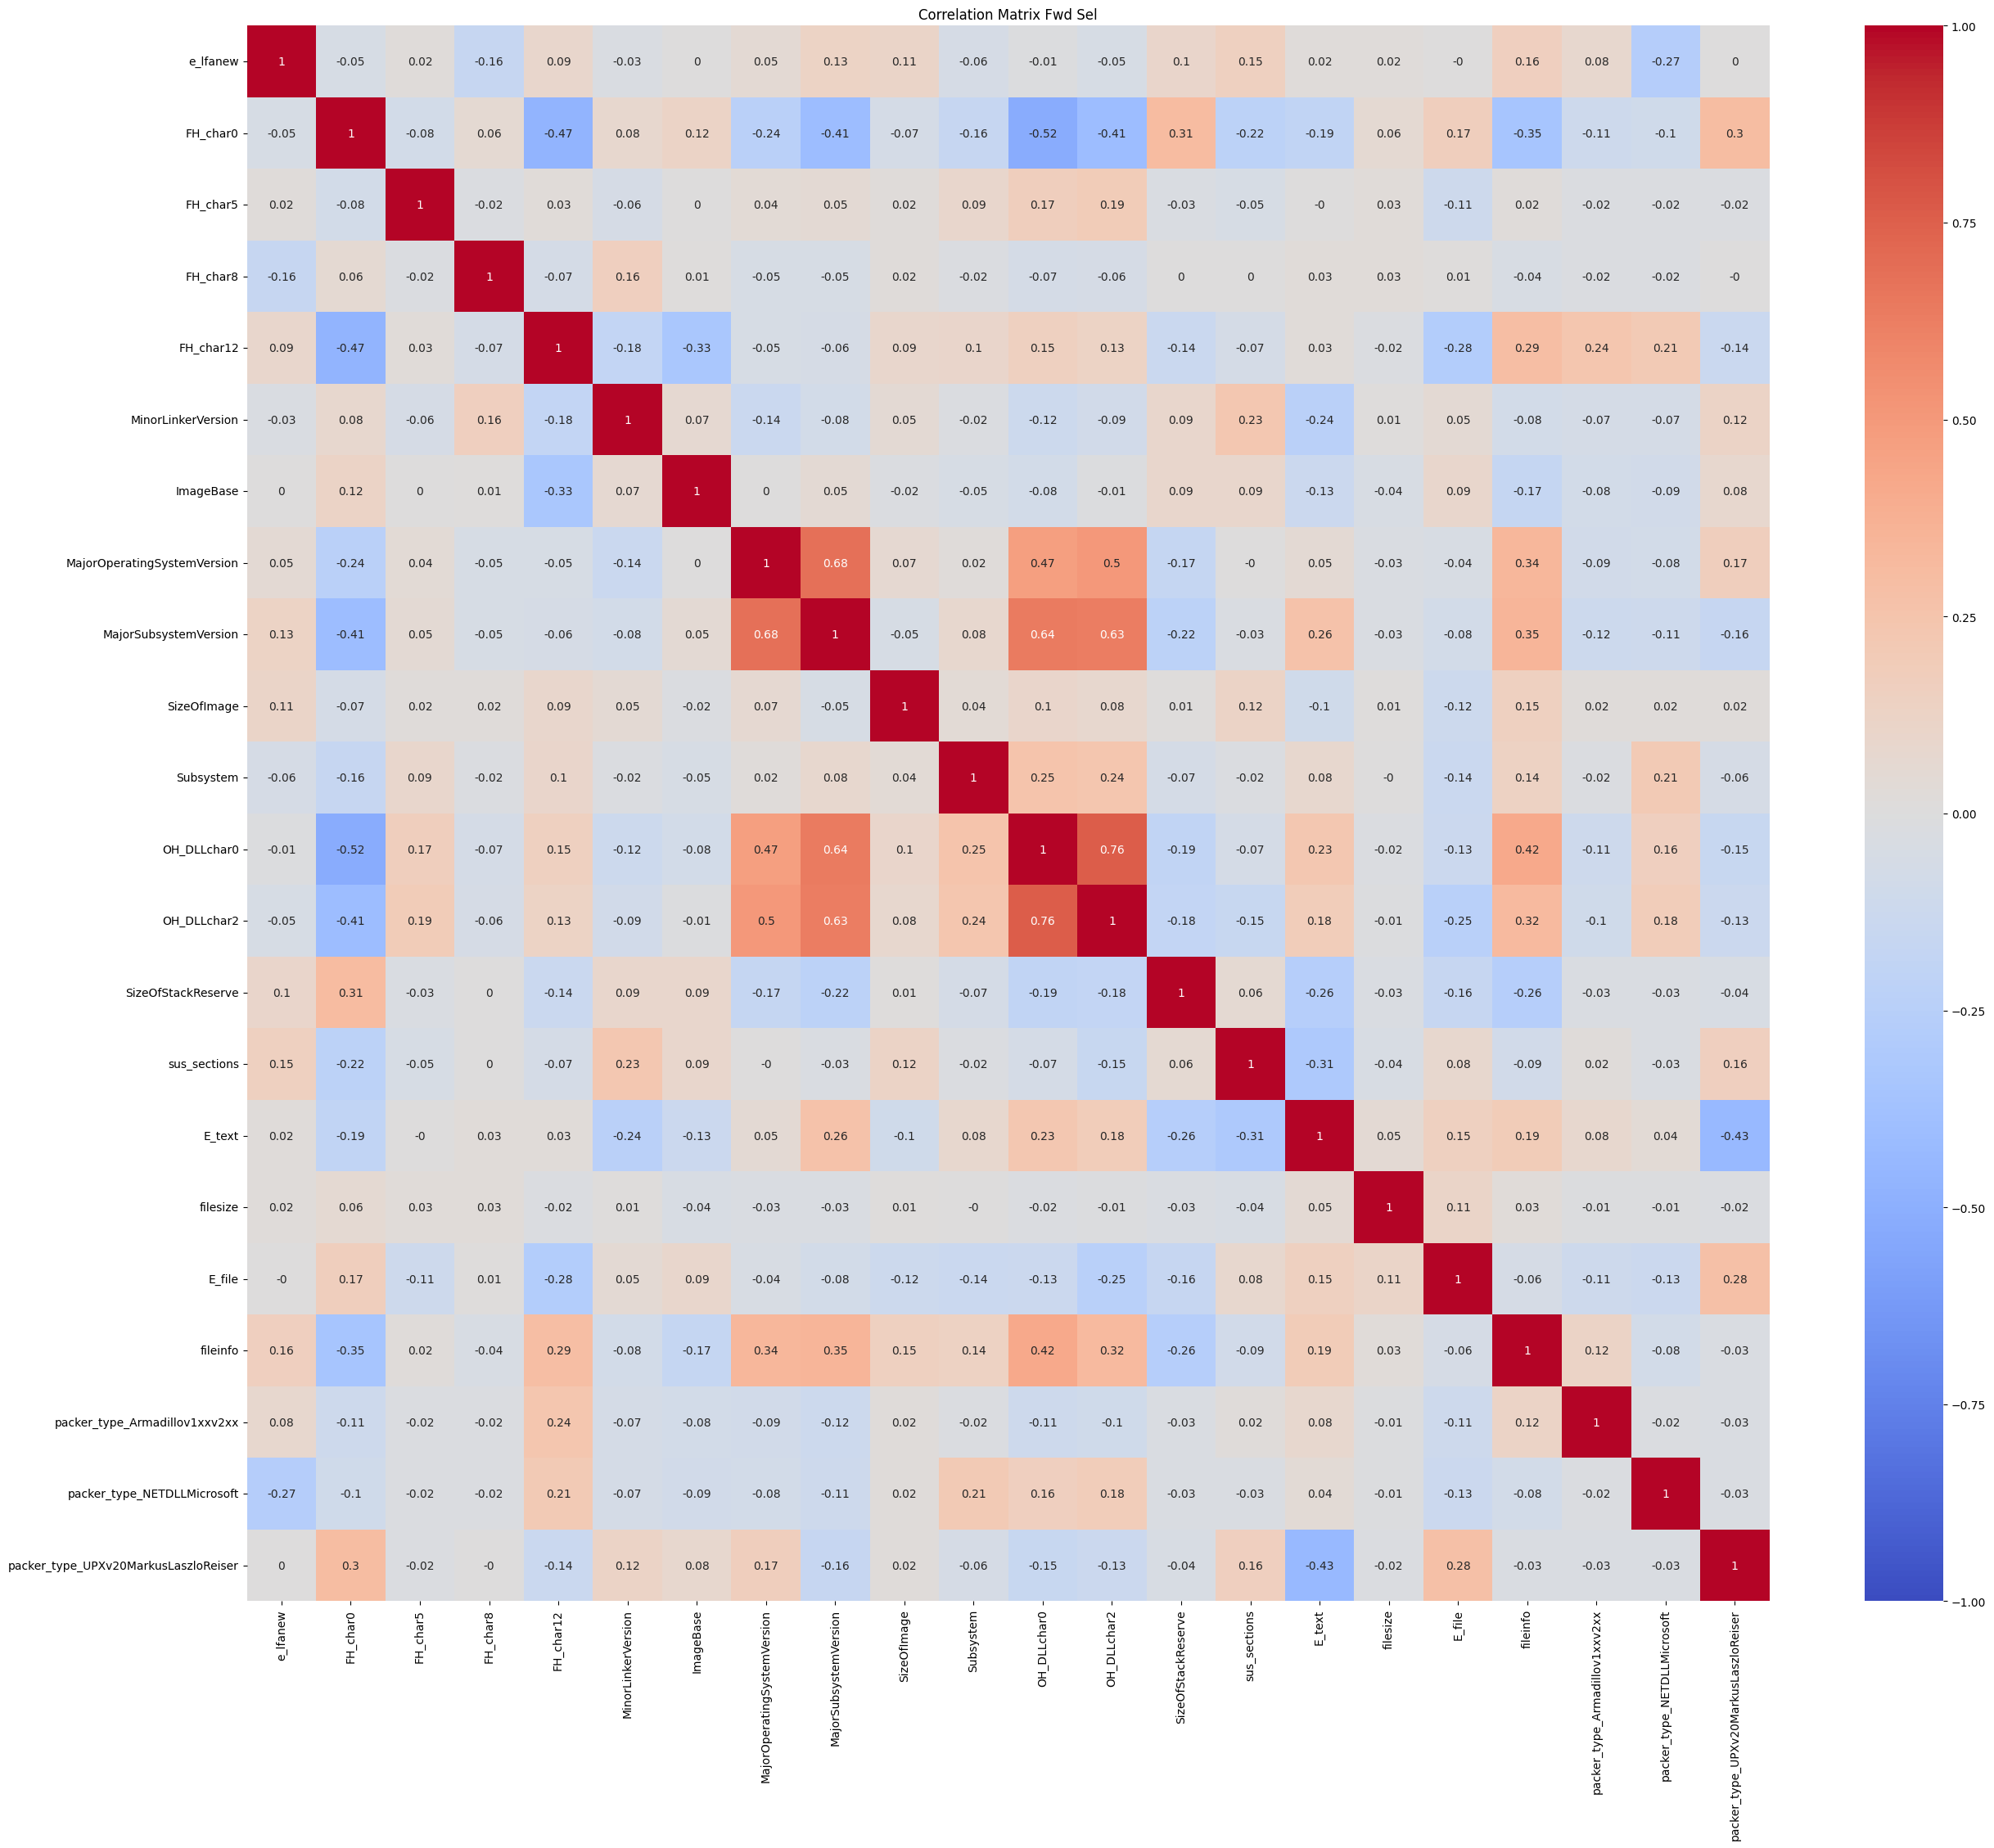

In [182]:
corr_matrix = train_x_filtered.corr(method='pearson').round(2)

plt.figure(figsize=(30,25))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Fwd Sel')
plt.show()

In [183]:
train_x_filtered.dropna()

,e_lfanew,FH_char0,FH_char5,FH_char8,FH_char12,MinorLinkerVersion,ImageBase,MajorOperatingSystemVersion,MajorSubsystemVersion,SizeOfImage,...,OH_DLLchar2,SizeOfStackReserve,sus_sections,E_text,filesize,E_file,fileinfo,packer_type_Armadillov1xxv2xx,packer_type_NETDLLMicrosoft,packer_type_UPXv20MarkusLaszloReiser
2104,200,0,0,0,1,0,1,4,5,1,...,0,1048576,0,1.587419,434976,5.994041,1,0,0,0
1545,232,1,0,0,0,10,1,4,4,1,...,0,1048576,0,6.581199,34872,6.443962,1,0,0,0
1048,128,0,0,0,0,0,1,4,4,1,...,1,1048576,1,5.853478,31616,6.067109,0,0,1,0
792,256,1,0,0,0,0,1,5,4,1,...,1,1048576,0,6.256483,77888,6.076877,1,0,0,0
4505,216,0,0,0,0,0,1,4,5,1,...,0,1048576,0,6.536896,169472,7.255207,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993,248,0,0,0,1,0,1,4,4,1,...,0,1048576,1,6.464950,113736,5.938135,0,0,0,0
70,240,0,0,0,0,10,1,6,6,1,...,1,262144,1,6.027952,319488,6.802624,1,0,0,0
2878,224,1,0,0,0,15,1,4,4,1,...,0,1048576,0,5.672433,73728,6.959375,1,0,0,0
1950,256,0,0,0,1,0,0,4,4,1,...,0,1048576,1,5.910635,90112,5.670780,1,0,0,0


## -------------

## 4: Processing

In [184]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()


# Fit the scaler on the training data and transform it
train_x_scaled = scaler.fit_transform(train_x_filtered)

# Convert the scaled data back to a DataFrame (optional, but helpful for keeping track of feature names)
train_x_scaled = pd.DataFrame(train_x_scaled, columns=train_x_filtered.columns)

test_filtered_x = test_x[train_x_filtered.columns]

test_x_scaled = scaler.transform(test_filtered_x)

train_x_scaled.describe()


,e_lfanew,FH_char0,FH_char5,FH_char8,FH_char12,MinorLinkerVersion,ImageBase,MajorOperatingSystemVersion,MajorSubsystemVersion,SizeOfImage,...,OH_DLLchar2,SizeOfStackReserve,sus_sections,E_text,filesize,E_file,fileinfo,packer_type_Armadillov1xxv2xx,packer_type_NETDLLMicrosoft,packer_type_UPXv20MarkusLaszloReiser
count,4.040000e+03,4.040000e+03,4.040000e+03,4.040000e+03,4.040000e+03,4.040000e+03,4.040000e+03,4.040000e+03,4.040000e+03,4.040000e+03,...,4.040000e+03,4.040000e+03,4.040000e+03,4.040000e+03,4.040000e+03,4.040000e+03,4.040000e+03,4.040000e+03,4.040000e+03,4.040000e+03
mean,6.947138e-17,-8.793846e-18,-6.947138e-17,-6.683323e-17,1.934646e-17,1.934646e-17,7.738584e-17,-2.752474e-16,-5.390627e-16,6.045769e-17,...,1.600480e-16,-1.407015e-17,7.826523e-17,3.324074e-16,-1.055261e-17,-3.069052e-16,-9.365446e-17,-6.595384e-18,-8.793846e-18,-3.517538e-18
std,1.000124e+00,1.000124e+00,1.000124e+00,1.000124e+00,1.000124e+00,1.000124e+00,1.000124e+00,1.000124e+00,1.000124e+00,1.000124e+00,...,1.000124e+00,1.000124e+00,1.000124e+00,1.000124e+00,1.000124e+00,1.000124e+00,1.000124e+00,1.000124e+00,1.000124e+00,1.000124e+00
min,-4.520194e+00,-7.538720e-01,-1.448292e-01,-1.318180e-01,-6.254475e-01,-4.882158e-01,-2.554071e+00,-4.620203e+00,-4.880424e+00,-7.035624e+00,...,-6.434833e-01,-4.314488e-01,-1.113475e+00,-1.930797e+00,-1.428805e-01,-3.163432e+00,-1.086392e+00,-1.518019e-01,-1.356533e-01,-2.252004e-01
25%,-2.956897e-01,-7.538720e-01,-1.448292e-01,-1.318180e-01,-6.254475e-01,-4.882158e-01,3.915318e-01,-6.136304e-01,-7.957104e-01,1.421338e-01,...,-6.434833e-01,-2.081663e-01,-2.155829e-01,-4.191124e-01,-1.313072e-01,-6.453000e-01,-1.086392e+00,-1.518019e-01,-1.356533e-01,-2.252004e-01
50%,2.215966e-01,-7.538720e-01,-1.448292e-01,-1.318180e-01,-6.254475e-01,-4.882158e-01,3.915318e-01,-6.136304e-01,-7.957104e-01,1.421338e-01,...,-6.434833e-01,-2.081663e-01,-2.155829e-01,4.828449e-01,-1.195332e-01,3.771064e-03,9.204778e-01,-1.518019e-01,-1.356533e-01,-2.252004e-01
75%,5.664541e-01,1.326485e+00,-1.448292e-01,-1.318180e-01,1.598855e+00,4.111877e-01,3.915318e-01,3.880127e-01,5.658609e-01,1.421338e-01,...,1.554042e+00,-2.081663e-01,6.823088e-01,6.273013e-01,-8.537881e-02,8.806335e-01,9.204778e-01,-1.518019e-01,-1.356533e-01,-2.252004e-01
max,8.153319e+00,1.326485e+00,6.904687e+00,7.586219e+00,1.598855e+00,2.244657e+01,3.915318e-01,5.396228e+00,1.927432e+00,1.421338e-01,...,1.554042e+00,6.713591e+00,4.273876e+00,1.219127e+00,3.285385e+01,1.511579e+00,9.204778e-01,6.587534e+00,7.371734e+00,4.440490e+00


In [185]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


# Define the KNN model
svm = SVC()

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear']
}


# Set up GridSearchCV to find the best k with cross-validation
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')
grid_search.fit(train_x_scaled, train_y_proc)

# Extracting the results
results = pd.DataFrame(grid_search.cv_results_)

# Step 4: Extract the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best CV Score: {best_score:.4f}")

Best Parameters: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
Best CV Score: 0.9800


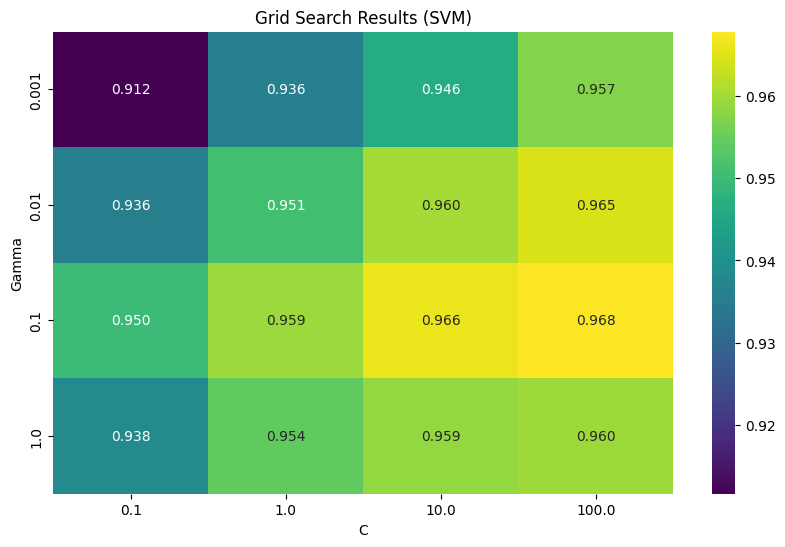

In [186]:
# Extract the parameter values and corresponding mean test scores
C_values = results['param_C'].astype(float)
gamma_values = results['param_gamma'].astype(float)
mean_test_scores = results['mean_test_score']

# Create a pivot table to arrange the results for heatmap
heatmap_data = pd.pivot_table(
    results,
    values='mean_test_score',
    index='param_gamma',
    columns='param_C'
)

# Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap='viridis')
plt.title('Grid Search Results (SVM)')
plt.xlabel('C')
plt.ylabel('Gamma')
plt.show()

In [187]:
# Initialize the SVM classifier
svm_classifier = SVC(kernel=best_params['kernel'], C=best_params['C'], gamma=best_params['gamma'],random_state=42)

# Train the SVM model
svm_classifier.fit(train_x_scaled, train_y_proc)

SVC(C=100, gamma=0.1, random_state=42)

              precision    recall  f1-score   support

      Normal     0.9527    0.9825    0.9674       513
     Malware     0.9825    0.9527    0.9674       529

    accuracy                         0.9674      1042
   macro avg     0.9676    0.9676    0.9674      1042
weighted avg     0.9678    0.9674    0.9674      1042



/home/francescodm/Documents/Uni/AI/ai-project/.venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/home/francescodm/Documents/Uni/AI/ai-project/.venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


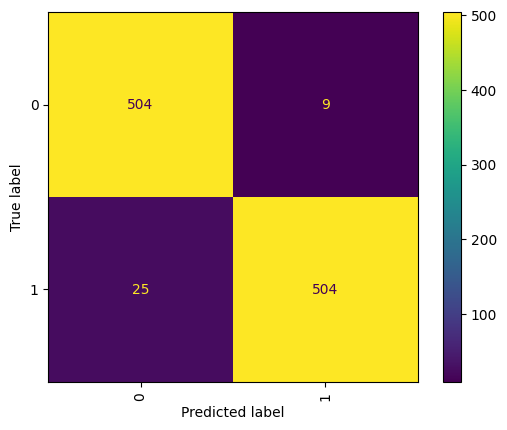

In [188]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

pred_y = svm_classifier.predict(test_x_scaled)

print(classification_report(test_y, pred_y, target_names=['Normal', 'Malware'], digits=4))

ConfusionMatrixDisplay.from_estimator(svm_classifier, test_x_scaled, test_y, xticks_rotation="vertical")

In [189]:
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import GridSearchCV

# Step 1: Define the parameter grid for 'random_state'
param_grid = {
    'hidden_layer_sizes' : [(25,),(50,),(75,),(100,), (25,25),(50,25),(100,50),(100,50,25)]
}

# Step 2: Initialize the MLPClassifier with other fixed parameters
mlp = MLPClassifier(max_iter=750, activation='relu')

# Step 3: Perform Grid Search
grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(train_x_scaled, train_y_proc)

# Extracting the results
results = pd.DataFrame(grid_search.cv_results_)

# Step 4: Extract the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best CV Score: {best_score:.4f}")

Best Parameters: {'hidden_layer_sizes': (100, 50)}
Best CV Score: 0.9822


In [190]:
mlp_best = MLPClassifier(hidden_layer_sizes=best_params['hidden_layer_sizes'],
                         max_iter=300, activation='relu')
mlp_best.fit(train_x_scaled, train_y_proc)


MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=300)

/tmp/ipykernel_612159/930399298.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Hidden Layer Sizes', y='Mean Test Score', data=plot_data, palette="viridis")


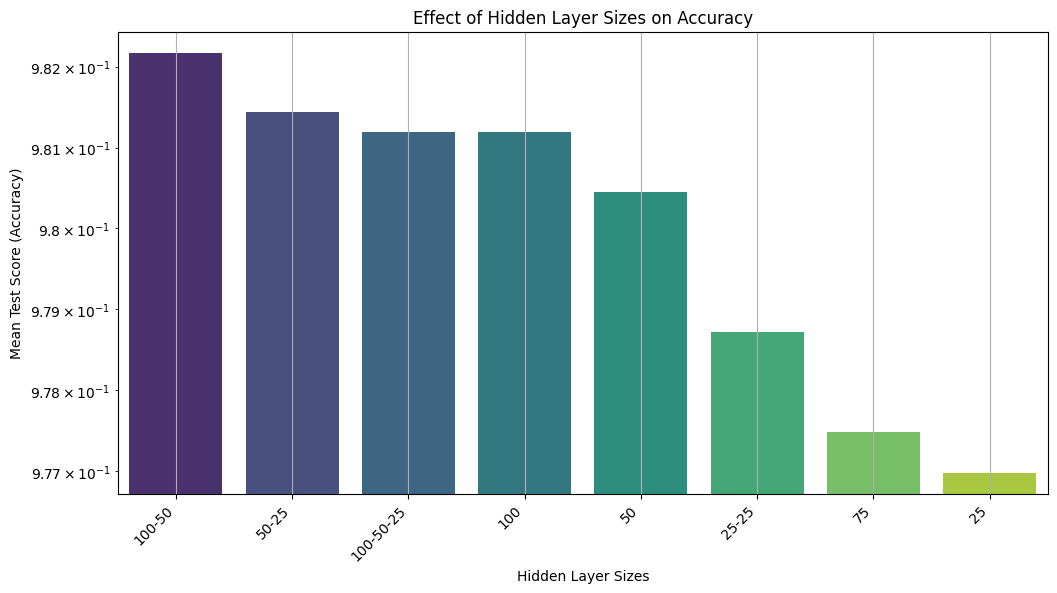

In [191]:
# Extracting the hidden layer sizes and corresponding mean test scores
hidden_layer_sizes = ['-'.join(map(str, size)) for size in results['param_hidden_layer_sizes']]
mean_test_scores = results['mean_test_score']

# Create a DataFrame for easier plotting
plot_data = pd.DataFrame({
    'Hidden Layer Sizes': hidden_layer_sizes,
    'Mean Test Score': mean_test_scores
})

# Sorting the DataFrame based on the hidden layer sizes for better visualization
plot_data = plot_data.sort_values('Mean Test Score', ascending=False)

# Plotting the results
plt.figure(figsize=(12, 6))
sns.barplot(x='Hidden Layer Sizes', y='Mean Test Score', data=plot_data, palette="viridis")

plt.yscale('log')
# Adding labels and title
plt.xlabel('Hidden Layer Sizes')
plt.ylabel('Mean Test Score (Accuracy)')
plt.title('Effect of Hidden Layer Sizes on Accuracy')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()

              precision    recall  f1-score   support

      Normal     0.9786    0.9786    0.9786       513
     Malware     0.9792    0.9792    0.9792       529

    accuracy                         0.9789      1042
   macro avg     0.9789    0.9789    0.9789      1042
weighted avg     0.9789    0.9789    0.9789      1042



/home/francescodm/Documents/Uni/AI/ai-project/.venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/home/francescodm/Documents/Uni/AI/ai-project/.venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


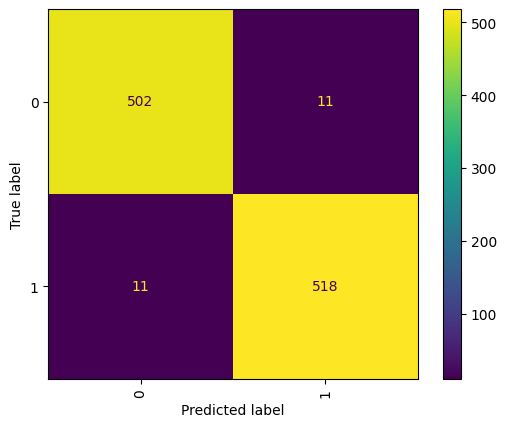

In [192]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

pred_y_mlp = mlp_best.predict(test_x_scaled)

print(classification_report(test_y, pred_y_mlp, target_names=['Normal', 'Malware'], digits=4))

ConfusionMatrixDisplay.from_estimator(mlp_best, test_x_scaled, test_y, xticks_rotation="vertical")

## 5: Validation
